In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import mediapy as media
import torch.optim as optim
from einops import rearrange
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
# 1) imports
import json
import torch
from torch.nn import functional as F
import torch.nn as nn
from main import LitDenoiser, MNISTDataModule, ImageDataModule  # assumes train_denoiser.py is on your PYTHONPATH
from model import *
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mc

import mediapy as media

from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
def vis_patches(patches, title="", figsize=None, colorbar=False,
                      ncol=None, pad_value="min", show=True,
                      return_tensor=False, vmin=None, vmax=None, fontsize=20,
                      dpi=None, normalize = False,cmap_value =2,padding=1):
    """
    Given patches of images in the dataset, create a grid and display it.

    Parameters
    ----------
    patches : Tensor of (batch_size, pixels_per_patch) or 
        (batch_size, channels, pixels_per_patch)

    title : String; title of figure. Optional.
    """
    
    if normalize:
        # print(patches.norm(dim=[-1,-2],keepdim=True).shape)
        patches=patches-patches.mean(dim=(1,2),keepdim=True)
        # patches=patches/patches.norm(dim=[-1,-2],keepdim=True)
        p2p = patches.amax(dim=(1,2),keepdim=True)-patches.amin(dim=(1,2),keepdim=True).clamp(min=1e-8)
        patches=(patches/p2p).clamp(min=-cmap_value,max=cmap_value)
    
    if patches.dim() == 2:
        channels = 1
        patches.unsqueeze_(1)
    else:
        channels = patches.size(1)
    batch_size = patches.size(0)
    size = int(np.sqrt(patches.size(-1)))

    img_grid = []
    for i in range(batch_size):
        img = torch.reshape(patches[i], (channels, size, size))
        img_grid.append(img)

    if pad_value != 0:
        if pad_value == "min":
            pad_value = torch.min(patches)
        elif pad_value == "max":
            pad_value = torch.max(patches)

    if not ncol:
        ncol = int(np.sqrt(batch_size))
    out = make_grid(img_grid, padding=padding, nrow=ncol, pad_value=pad_value)
    # normalize between 0 and 1 for rgb
    if channels == 3:
        out = ((out - torch.min(out))/(torch.max(out) - torch.min(out))).permute(1, 2, 0)
    else:
        out = out[0]

    if show:
        plt.tick_params(axis='both', which='both', bottom=False, left=False,
                        labelbottom=False, labelleft=False)
        plt.xticks([])
        plt.yticks([])
        plt.title(title, fontsize=fontsize)
        fig = plt.gcf()
        ax = plt.gca()
        ax.set_frame_on(False)
        if figsize:
            fig.set_size_inches(figsize)
        if dpi:
            fig.set_dpi(dpi)
        if vmin is not None and vmax is not None:
            if channels != 3:
                plt.imshow(out, cmap="gray", vmin=vmin, vmax=vmax)
            else:
                plt.imshow(out, vmin=vmin, vmax=vmax)
        else:
            if channels != 3:
                plt.imshow(out, cmap="gray")
            else:
                plt.imshow(out)
        if colorbar:
            # this sometimes gets the colorbar to match height of the plot...?
            plt.colorbar(fraction=0.046, pad=0.04)

            # cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
            # cbar = fig.colorbar(cax)
            # cbar.ax.tick_params(labelsize=30) 
        plt.show()
    if return_tensor:
        return out

2026-01-22 00:58:50.107694: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/zeyu/minimal_scaling/model.py:499: SyntaxWarning: invalid escape sequence '\P'
  """
/home/zeyu/minimal_scaling/model.py:3548: SyntaxWarning: invalid escape sequence '\P'
  """
/home/zeyu/minimal_scaling/model.py:3683: SyntaxWarning: invalid escape sequence '\P'
  """


In [3]:
def load_net(BASE_DIR):

    # 3) load the config
    with open(f"{BASE_DIR}/config.json", "r") as f:
        config = json.load(f)
    # print(config)
    # 4) rebuild the model (Lightning will wrap it, but we just need the raw module here)
    clean_config_dict  = {
        k: config[k] for k in [
            "in_channels", "num_basis", "eta_base", "n_iters_inter", "n_iters_intra",
            "kernel_size", "stride",
            "sigma","lr",
            "ema_halflife_kimg","ema_rampup_ratio",
            "model_arch", "eta_ls", 
            "P_mean","P_std", "edm_weighting",
            "jfb_no_grad_iters","jfb_with_grad_iters","jfb_reuse_solution","jfb_ddp_safe",
            "whiten_dim","T","frequency_groups","whiten_ks","pyramid",
            "h_groups","groups","energy_function","per_dim_threshold",
            "multiscale", "constraint_energy", "intra", "num_classes", "cond_drop_prob"
            # "k_inter"
        ]
    }
    clean_config_dict["learning_horizontal"] = not config["no_learning_horizontal"]
    clean_config_dict["stable"] = config.get("stable")
    # jfb_reuse_solution_rate
    print(clean_config_dict)
    model = LitDenoiser(**clean_config_dict)
    model.eval()  # important!
    model = model.to(device)

    # 5) load the checkpoint
    #    if you used save_weights_only=True you need to wrap it in state_dict
    # ema_model.ckpt
    ckpt_path = f"{BASE_DIR}/{config.get('best_ckpt', 'ema_model.ckpt')}"
    state = torch.load(ckpt_path, map_location="cpu")
    if "state_dict" in state:
        model.ema_model.load_state_dict(state["state_dict"])
    else:
        model.ema_model.load_state_dict(state)

    return config,model

In [4]:
device = "cuda:0"
# BASE_DIR3 = "pretrained_model/scaling-mnist-exercise/00133_simple-net-small-cond-drop-32"
BASE_DIR3 = "model_banks/mnist_condition"
config,net3 = load_net(BASE_DIR3)
net_infer = net3

batch_size = 32
dm = MNISTDataModule(data_dir="./data", batch_size=batch_size)
dm.setup()  # runs prepare_data + splits
test_loader = dm.test_dataloader()
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

# avg_snr = evaluate_snr(model, test_loader,device,sigma =sigma)

{'in_channels': 1, 'num_basis': [16, 32], 'eta_base': 0.2, 'n_iters_inter': 3, 'n_iters_intra': 1, 'kernel_size': 7, 'stride': 2, 'sigma': [0.01, 1.0], 'lr': 0.0003, 'ema_halflife_kimg': 500.0, 'ema_rampup_ratio': 0.05, 'model_arch': 'SC_simple', 'eta_ls': None, 'P_mean': -1.2, 'P_std': 1.2, 'edm_weighting': True, 'jfb_no_grad_iters': [0, 6], 'jfb_with_grad_iters': [1, 3], 'jfb_reuse_solution': False, 'jfb_ddp_safe': False, 'whiten_dim': None, 'T': 0.0, 'frequency_groups': None, 'whiten_ks': 3, 'pyramid': False, 'h_groups': 2, 'groups': 2, 'energy_function': 'elastic', 'per_dim_threshold': False, 'multiscale': False, 'constraint_energy': 'SC', 'intra': False, 'num_classes': 10, 'cond_drop_prob': 0.1, 'learning_horizontal': True, 'stable': False}
<class 'model.RecurrentConvNLayer_simple'>
EMA <class 'model.RecurrentConvNLayer_simple'>


/tmp/ipykernel_1756214/3162173700.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location="cpu")


In [72]:
import torch
import math

@torch.no_grad()
def denoiser_to_score(x_noisy, sigmas, model, n_iters=5,
                      n_components=None,steer_components=None,neuron_steer=None,T=0,class_labels=None,CFG_scale=0.0, noise_emb=None):
    """
    x_noisy : (B, C, H, W)
    sigmas  : scalar float or tensor of shape (B,)
    model   : your denoiser, called as model(x, noise_labels=..., infer_mode=True, n_iters=...)
    """
    B = x_noisy.size(0)
    device = x_noisy.device
    dtype = x_noisy.dtype

    if not torch.is_tensor(sigmas) or len(sigmas.shape)==0:
        sigmas = torch.full((B,), float(sigmas), device=device, dtype=dtype)
    else:
        sigmas = sigmas.to(device=device, dtype=dtype)

    # Denoised estimate (posterior mean)
    # denoised = model(x_noisy, noise_labels=sigmas, infer_mode=True, n_iters=n_iters,n_components=n_components,steer_components=steer_components,neuron_steer=neuron_steer,T=T)
    denoised = model(x_noisy, noise_labels=sigmas, class_labels = class_labels, CFG_scale=CFG_scale, noise_emb=noise_emb)

    sigma_reshaped = sigmas.view(B, 1, 1, 1)
    score = (denoised - x_noisy) / (sigma_reshaped ** 2)
    return score

@torch.no_grad()
def annealed_langevin_dynamics(model,
                               shape,
                               sigmas,
                               n_steps_each=100,
                               base_step_size=1e-5,
                               n_iters_denoiser=5,
                               device='cuda',
                              record_per_steps=5,
                               start_img = None,
                               conditons = None,
                               class_id=None,
                               CFG_scale=0.0,
                               noise_emb=None
                              ):
    """
    Annealed Langevin dynamics using a denoiser-based score.

    model          : your denoiser (net_infer.model)
    shape          : (B, C, H, W)
    sigmas         : 1D tensor or list of noise levels [sigma_L, ..., sigma_1]
    n_steps_each   : Langevin steps per noise level
    base_step_size : base epsilon; we scale with sigma^2
    conditons: 
    """
    B, C, H, W = shape

    sigmas = torch.as_tensor(sigmas, device=device, dtype=torch.float32)
    # Start from Gaussian with largest sigma
    if start_img is None:
        x = torch.randn(shape, device=device) * sigmas[0]
    else:
        x = start_img.to(device)
    x_hist = []
    k=0

    class_labels = torch.full((B,), float(class_id), device=device)
    for sigma in sigmas:
        # Common heuristic: scale step size with sigma^2
        eps = base_step_size * (sigma ** 2)
        # eps = base_step_size * sigma
        # print(eps)
        # print(sigma)
        sigma = torch.full((B,), float(sigma), device=device)
        for _ in range(n_steps_each):
            
            noise_emb = model.get_embedding(x,sigma,class_labels)
            noise_emb_uncond = model.get_embedding(x, sigma, torch.full((B,), model.null_class, device=x.device, dtype=torch.long))            
            # print(noise_emb_uncond[1].shape)
            noise_emb_uncond[1][:,1] = noise_emb[1][:,1]
            noise_emb=noise_emb_uncond
            score = denoiser_to_score(x, sigma, model, n_iters=n_iters_denoiser,class_labels=class_labels, CFG_scale=CFG_scale, noise_emb=noise_emb)
            noise = torch.randn_like(x)

            x = x + 0.5 * eps * score + torch.sqrt(eps) * noise
            k+=1
            if k%record_per_steps==0:
                # technically we need to estimate the noise level here?
                # with torch.no_grad():
                #     x_denoised = model(x, noise_labels=sigma, infer_mode=True, n_iters=n_iters_denoiser)
                x_hist.append(x.cpu())
        
    # x = model(x, noise_labels=sigma, infer_mode=True, n_iters=n_iters_denoiser)
    x = model(x, noise_labels=sigma,class_labels=class_labels)
    x_hist.append(x.cpu())
    x_hist = torch.stack(x_hist)
    return x,x_hist


In [6]:
x_ls = []
counter = 0
for x, i in tqdm(val_loader):
    x_ls.append(x.cpu())
    if counter > 500:
        break
    counter +=1

B,c,h,w = x.shape
    
mean_img = torch.cat(x_ls).mean(0,keepdim=True).repeat(B,1,1,1)

100%|████████████████████████████████████████| 157/157 [00:00<00:00, 189.60it/s]


In [7]:
sigma_max, sigma_min, num_levels = 1.0, 0.05, 30

B=32
mean_img = torch.cat(x_ls).mean(0,keepdim=True).repeat(B,1,1,1)
start_img = mean_img + torch.randn_like(mean_img)*sigma_max
start_img=start_img.to(device)

sigmas = torch.linspace(sigma_max,sigma_min,num_levels)

In [8]:
net_infer.ema_model.cond_drop_prob = 0 

In [44]:
samples,x_hist = annealed_langevin_dynamics(
    model=net_infer.ema_model,
    shape=(B, c, h, w),
    sigmas=sigmas,
    n_steps_each=20,
    base_step_size=0.2,
    n_iters_denoiser=5,
    device=device,
    record_per_steps=20,
    start_img = start_img,
    class_id=8,
    CFG_scale=0.1,
    noise_emb = None
)

In [ ]:

viz_img = rearrange(x_hist[::5, ::], "h1 w1 c h w -> (h1 h) (w1 w) c")
plt.figure(figsize = (20,15))
plt.imshow(viz_img,vmin= x_hist[-1].min(),vmax=x_hist[-1].max())
plt.axis('off')

In [11]:
# viz_img = rearrange(x_hist[::5, ::], "h1 w1 c h w -> (h1 h) (w1 w) c")
# plt.figure(figsize = (20,15))
# plt.imshow(viz_img,vmin= x_hist[-1].min(),vmax=x_hist[-1].max())
# plt.axis('off')

In [73]:
def get_emb(model,noise_level,class_id,device='cuda'):
    B=1
    self = model
    
    noise_labels = torch.full((B,), float(noise_level), device=device, dtype=torch.float32)
    class_labels = torch.full((B,), class_id, device=device, dtype=torch.float32)
    emb = self.map_noise(noise_labels)                       # [B, Cn]
    emb = emb.reshape(B, 2, -1).flip(1).reshape(B, -1)       # swap sin/cos
    
    
    # ---- label embedding vector (same dim as emb) ----
    y_emb = self._get_label_embedding(
        class_labels=class_labels,
        B=B,
        device=device,
        dtype=emb.dtype,   # keep it compatible with emb before map_layer0
    )                                                         # [B, Cn]
    
    # Fuse conditioning (typical pattern: additive)
    emb = emb + y_emb
    
    noise_emb = F.relu(self.map_layer0(emb))
    # noise_emb = self.affine(noise_emb).unsqueeze(2).unsqueeze(3).to(x.dtype)  # [B, c1, 1, 1]
    noise_emb = [affine(noise_emb)[0] for affine in self.affines]
    return noise_emb

In [74]:
# type(10) is int

In [ ]:
# construct embedding at each noise level

In [ ]:
samples,x_hist = annealed_langevin_dynamics(
    model=net_infer.ema_model,
    shape=(B, c, h, w),
    sigmas=sigmas,
    n_steps_each=20,
    base_step_size=0.2,
    n_iters_denoiser=5,
    device=device,
    record_per_steps=20,
    start_img = start_img,
    class_id=1,
    CFG_scale=0.,
    noise_emb = None
)
viz_img = rearrange(x_hist[::5, ::], "h1 w1 c h w -> (h1 h) (w1 w) c")
plt.figure(figsize = (20,15))
plt.imshow(viz_img,vmin= x_hist[-1].min(),vmax=x_hist[-1].max())
plt.axis('off')

In [13]:
# closer look at the embedding values!

In [14]:
import math
import numpy as np
import matplotlib.pyplot as plt

def _to_numpy(y):
    # supports list / np / torch
    try:
        import torch
        if isinstance(y, torch.Tensor):
            return y.detach().cpu().numpy()
    except Exception:
        pass
    return np.asarray(y)

def plot_curve_grid(curves, x=None, ncols=8, figsize_per_cell=(3.6, 2.6), suptitle=None, name = "embedding",sharey=False,xlabel="noise_level"):
    """
    curves: iterable of 1D arrays (each curve is y-values)
    x     : None or 1D array or list of 1D arrays (same length as curves)
    """
    curves = list(curves)
    n = len(curves)
    nrows = math.ceil(n / ncols)

    fig_w = figsize_per_cell[0] * ncols
    fig_h = figsize_per_cell[1] * nrows
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), squeeze=False, sharey = sharey)

    for i in range(nrows * ncols):
        ax = axes[i // ncols][i % ncols]
        if i >= n:
            ax.axis("off")
            continue

        if i % ncols==0:
            ax.set_ylabel("activation level",fontsize = 15)

        if i // ncols==nrows-1:
            ax.set_xlabel(xlabel,fontsize = 15)

        y = _to_numpy(curves[i]).ravel()

        if x is None:
            xx = np.arange(len(y))
        else:
            if isinstance(x, (list, tuple)) and len(x) == n:
                xx = _to_numpy(x[i]).ravel()
            else:
                xx = _to_numpy(x).ravel()

        ax.plot(xx, y,marker='o', linestyle='None')
        ax.set_title(f"Neuron {i}", fontsize=15)
        ax.grid(True, alpha=0.3)

    if suptitle is not None:
        fig.suptitle(suptitle, y=1.02)

    plt.tight_layout()
    plt.savefig("./figures/"+ name + ".png")
    plt.show()

In [ ]:
ff_flatten_0 = net_infer.ema_model.levels[0].encoder.weight.data.flatten(1).cpu()
print(ff_flatten_0.norm(dim=1)[:8])
print(ff_flatten_0.norm(dim=1)[8:])
val,idx = ff_flatten_0.norm(dim=1).sort(descending =True)

In [8]:
# visualize embedding at all noise level
level_0 = torch.stack([get_emb(net_infer.ema_model,i,1)[0] for i in torch.linspace(0,1,10)])
level_1 =  torch.stack([get_emb(net_infer.ema_model,i,1)[1] for i in torch.linspace(0,1,10)])

NameError: name 'get_emb' is not defined

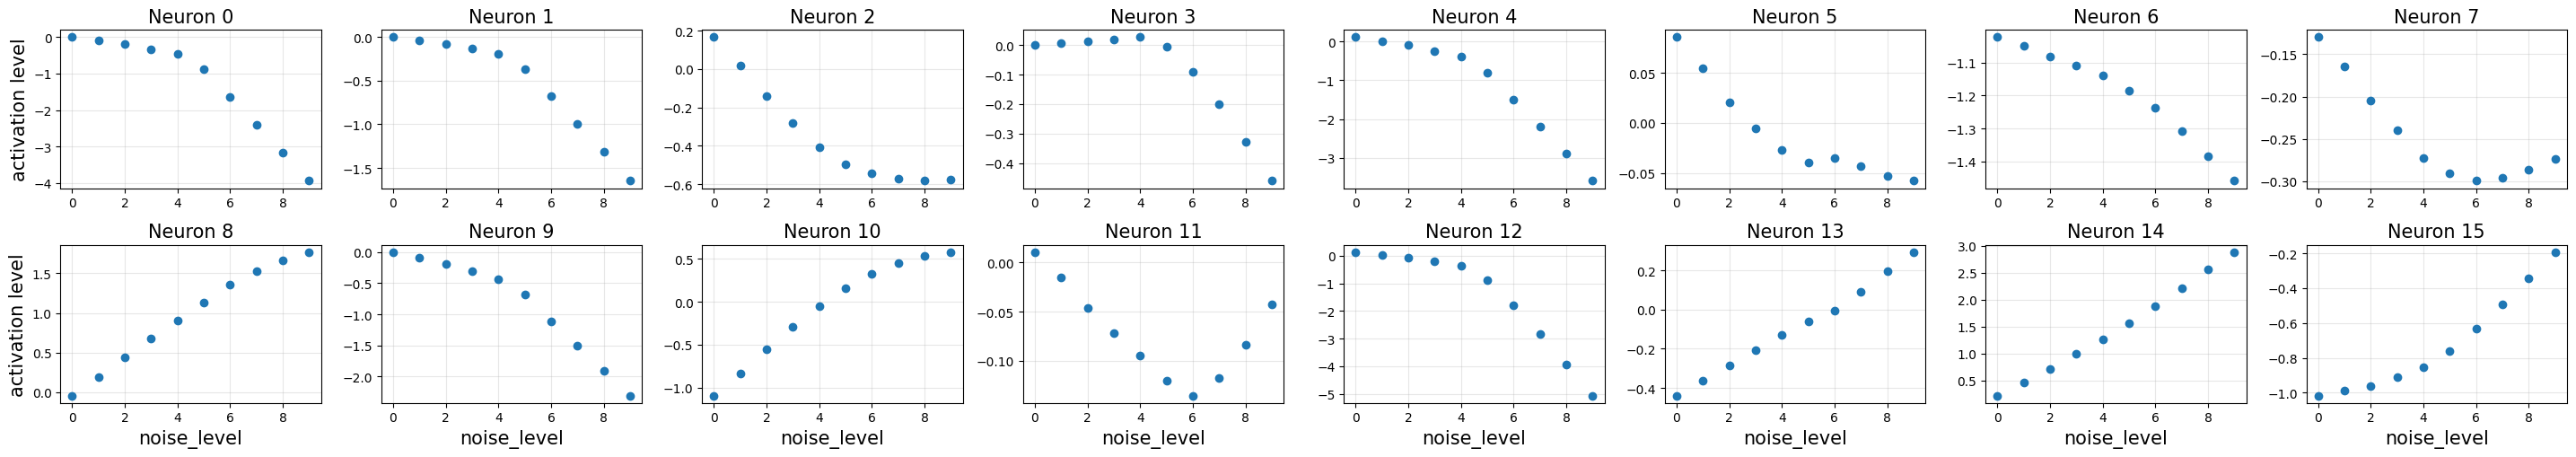

In [11]:
plot_curve_grid(level_0.T)

In [22]:
noise_level = 0.3
img_clean = torch.cat(x_ls)[torch.randperm(len(torch.cat(x_ls)))][:B].to(device)
# img_noisy = mean_img.to(device) +  torch.randn_like(img_clean)*noise_level
img_noisy =  img_clean + torch.randn_like(img_clean)*noise_level
sigma = torch.full((B,), float(noise_level), device=device, dtype=torch.float32)
class_labels = torch.full((B,), 0, device=device, dtype=torch.float32)
with torch.no_grad():
    a,decoded = net_infer.ema_model(img_noisy, noise_labels=sigma, return_feature = True, class_labels = class_labels)

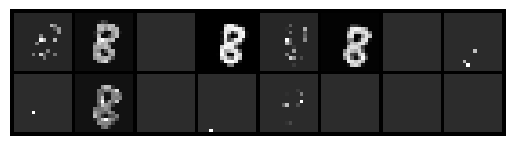

In [23]:
vis_patches(a[0][0].unsqueeze(1).flatten(2).cpu(),ncol=8,normalize=True)

In [24]:
# # reconstructing neuron at level 0:
# # TODO 1: find what neurons are reconstrucint the input
# recon_neuron_ls = [0,1,3,4,5,9,12]

In [25]:
# # how to visualize other neurons, are they dead?
# net_infer.ema_model.levels[0].M.weight[:,2][recon_neuron_ls]
#     # .flatten(1).norm(dim=1)

In [777]:
# assume a neuron is activate
# visualize where M take it, then threshold

# this is why needle plot work in the first place
# but for needle plot, we visualize the topk connection of each neuron.
# This is not right!!! we should define the "topk" but neuron's own property, self inhibitation + learned threshold
# This might allow us to visualize the effective connection for low (sparse coding) vs high noise level (horizontal connection) regime.

In [778]:
# visualize embedding at all noise level
level_0_class = torch.stack([get_emb(net_infer.ema_model,1.0,i)[0] for i in torch.arange(11)])
level_1_class =  torch.stack([get_emb(net_infer.ema_model,1.0,i)[1] for i in torch.arange(11)])

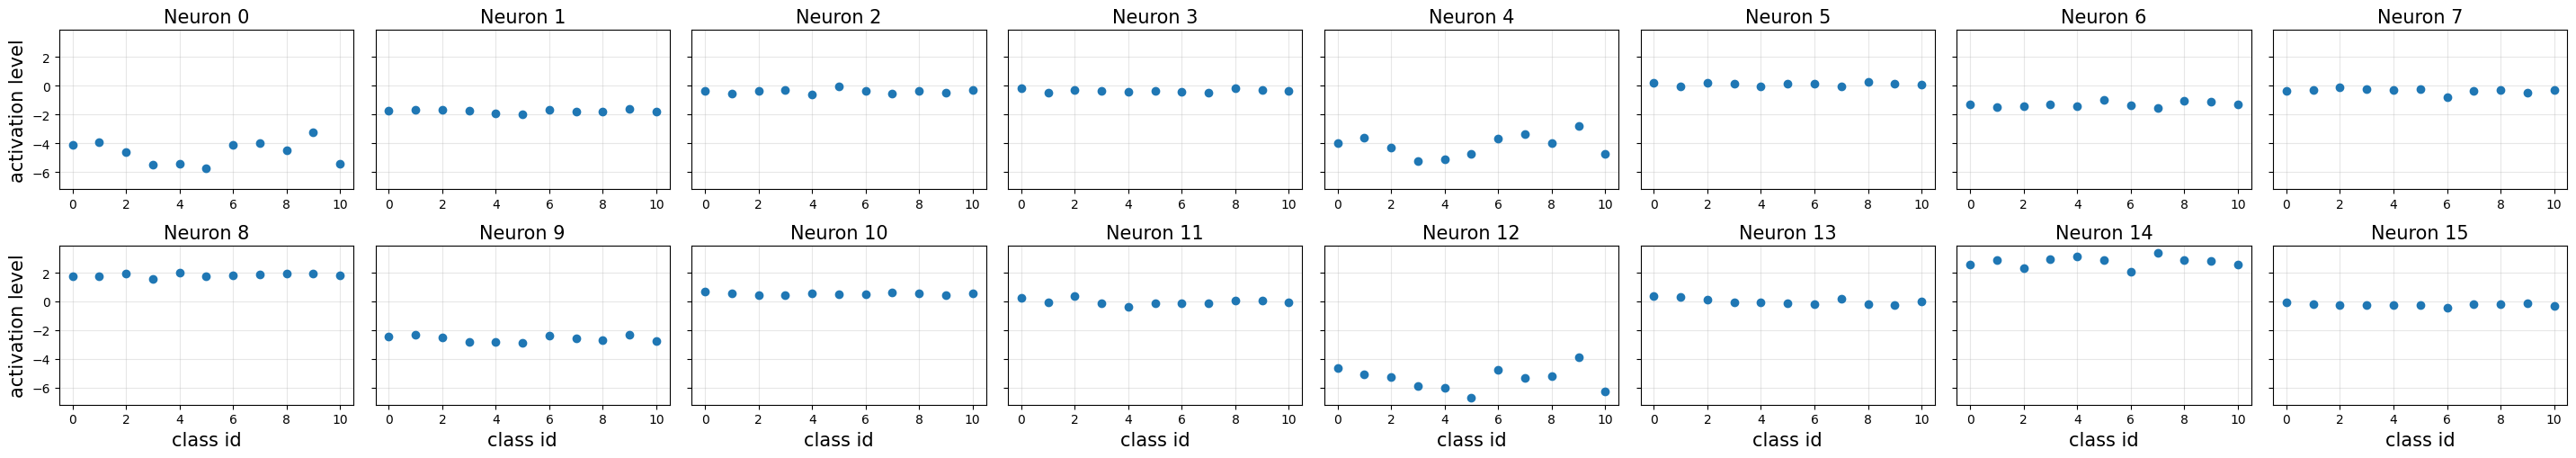

In [779]:
plot_curve_grid(level_0_class.T,sharey=True,xlabel="class id")

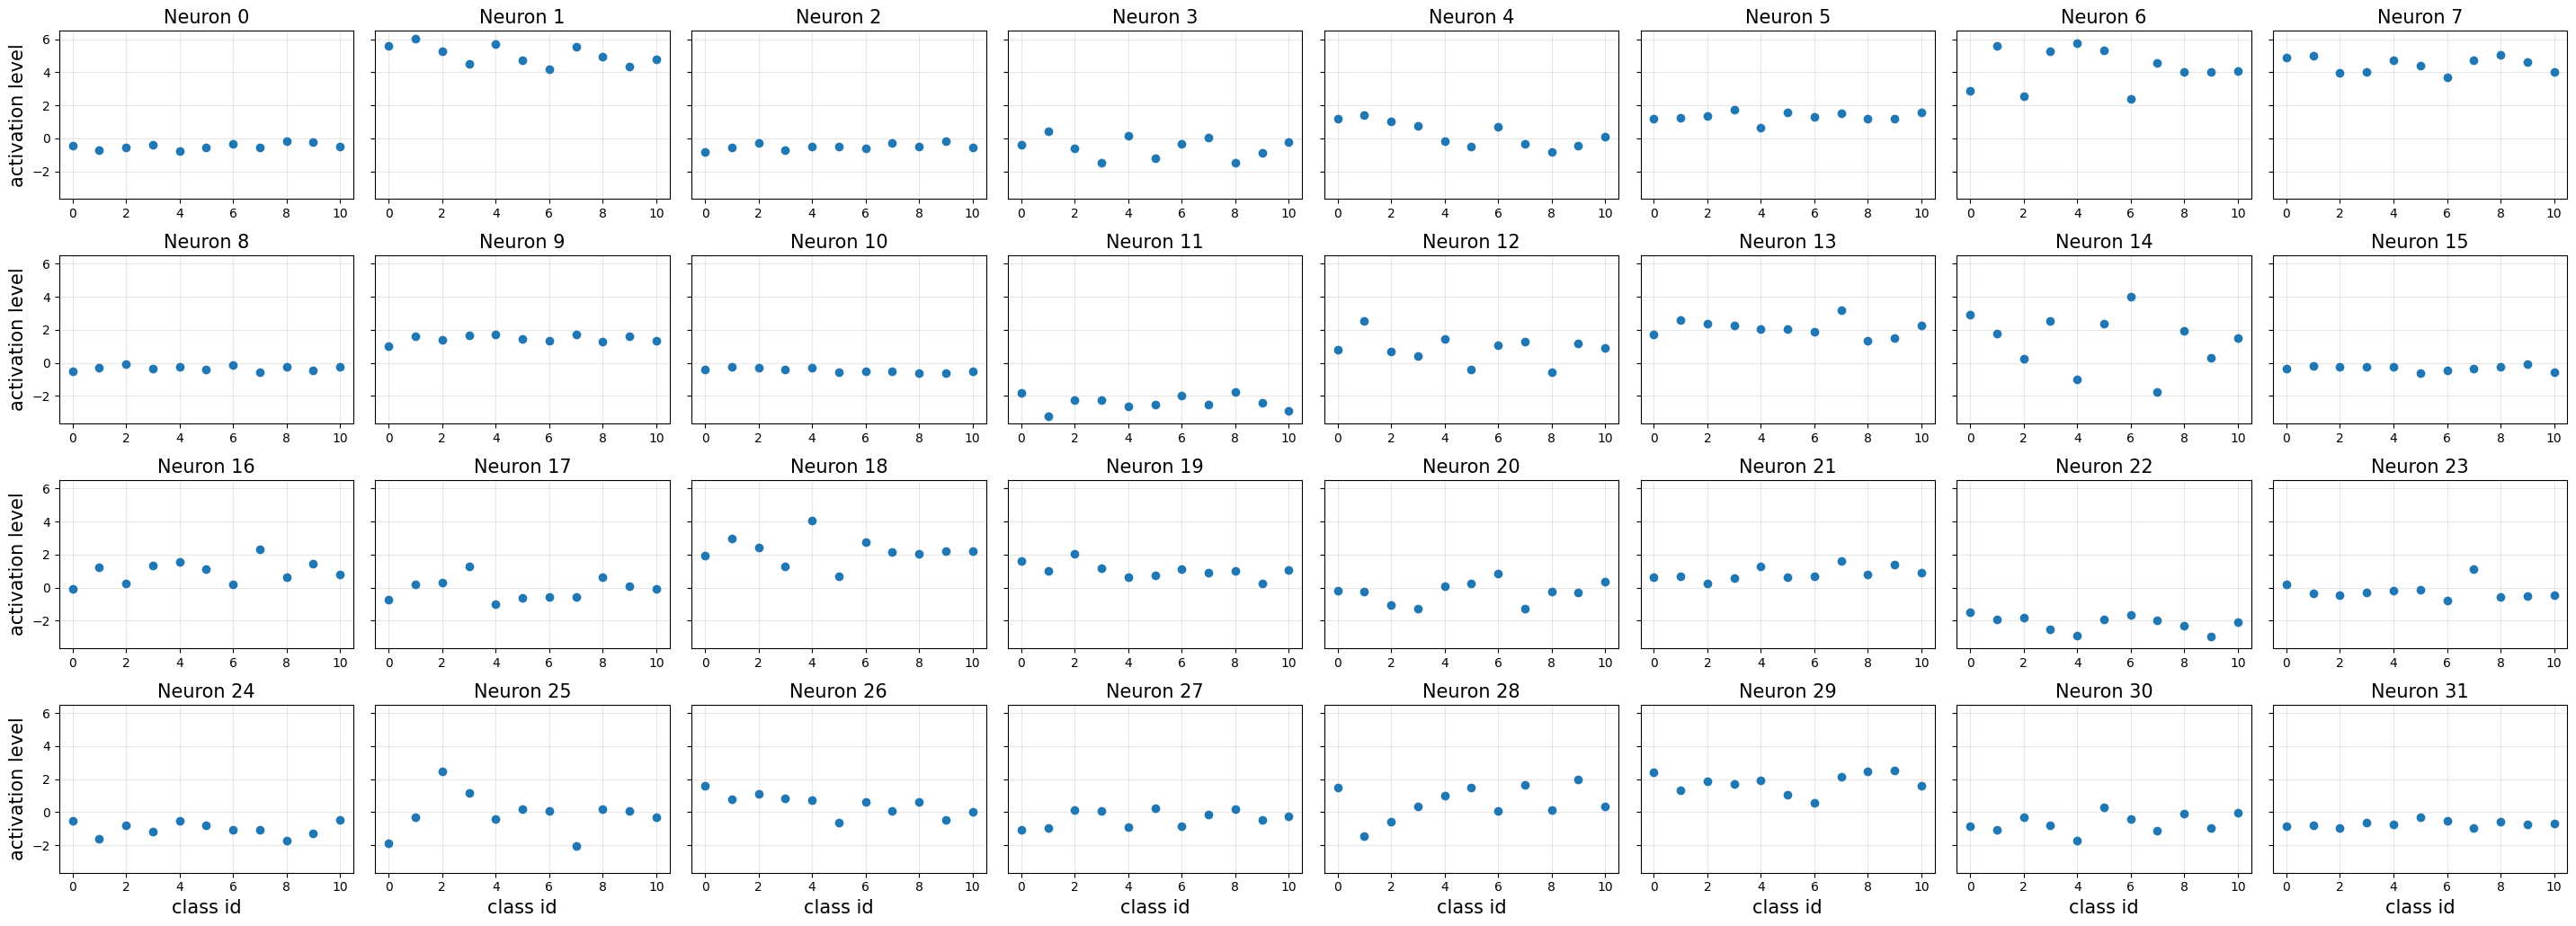

In [780]:
plot_curve_grid(level_1_class.T,sharey=True,xlabel="class id")

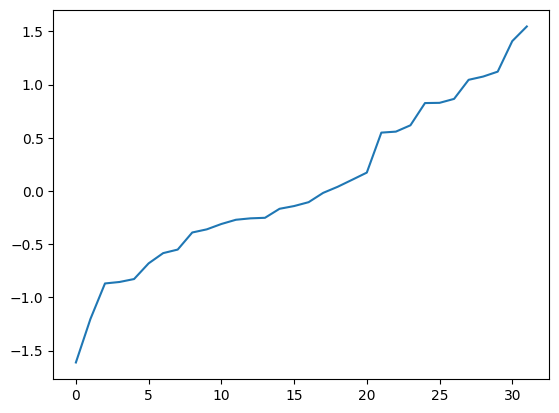

In [811]:
plt.plot((level_1_class - level_1_class[-1,:].unsqueeze(0))[0].sort().values.cpu())

In [62]:
# see how conditioning on a class change a channel over all noise level, compared to no conditioning

# visualize embedding at all noise level

class_emb_simgas = {}
for class_id in range(11):
    level_0 = torch.stack([get_emb(net_infer.ema_model,i,class_id)[0] for i in torch.linspace(0,1,10)])
    level_1 =  torch.stack([get_emb(net_infer.ema_model,i,class_id)[1] for i in torch.linspace(0,1,10)])
    class_emb_simgas[class_id] = (level_0,level_1)

class_emb_diff_simgas = {}
for class_id in range(11):
    level_0_diff_class_i = class_emb_simgas[class_id][0] - class_emb_simgas[10][0]
    level_1_diff_class_i = class_emb_simgas[class_id][1] - class_emb_simgas[10][1]
    class_emb_diff_simgas[class_id] = (level_0_diff_class_i,level_1_diff_class_i)

In [63]:
level = 1
class_id = 0
diff_vis = class_emb_diff_simgas[class_id][level]

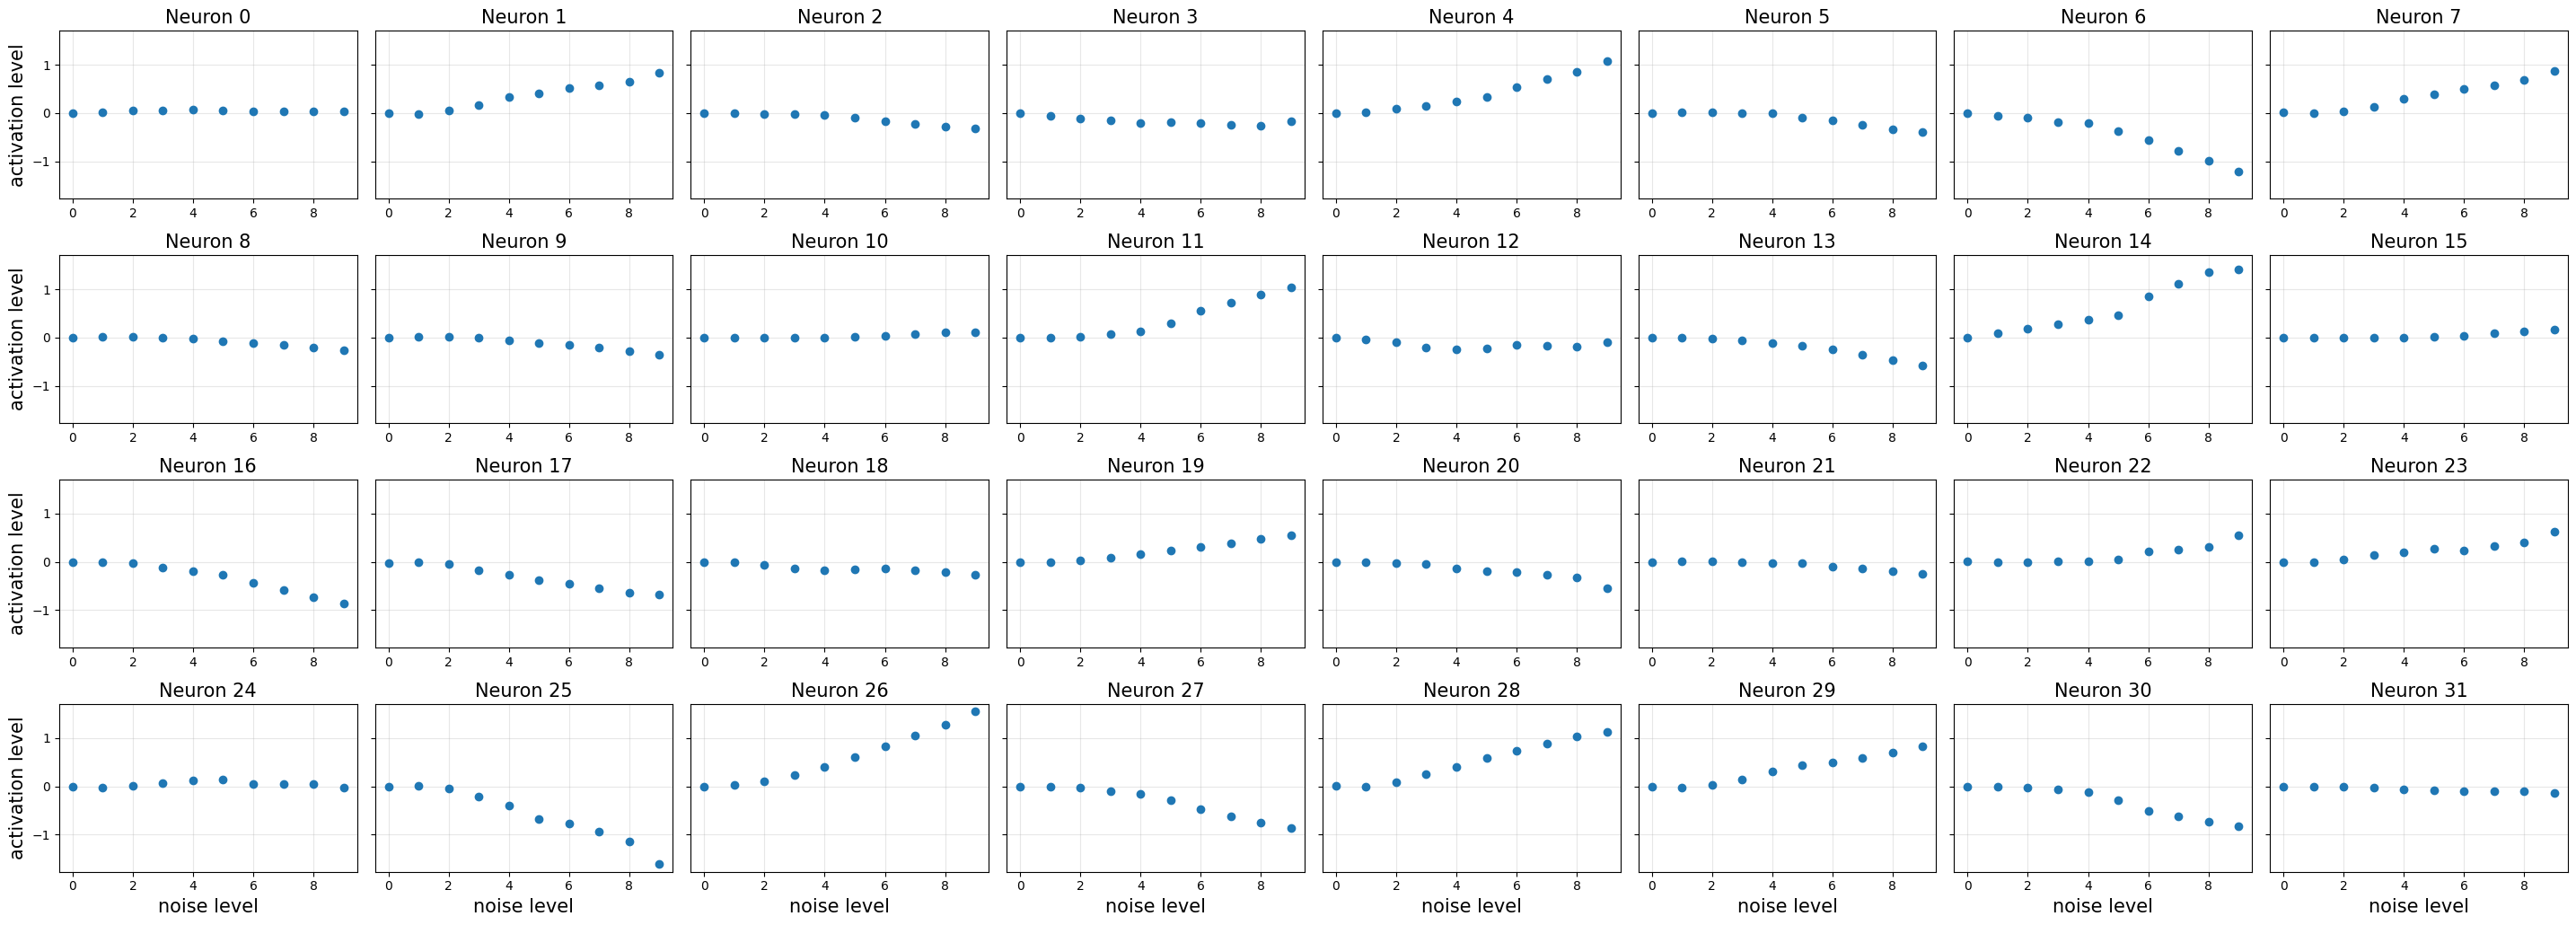

In [64]:
plot_curve_grid(diff_vis.T,sharey=True,xlabel="noise level")

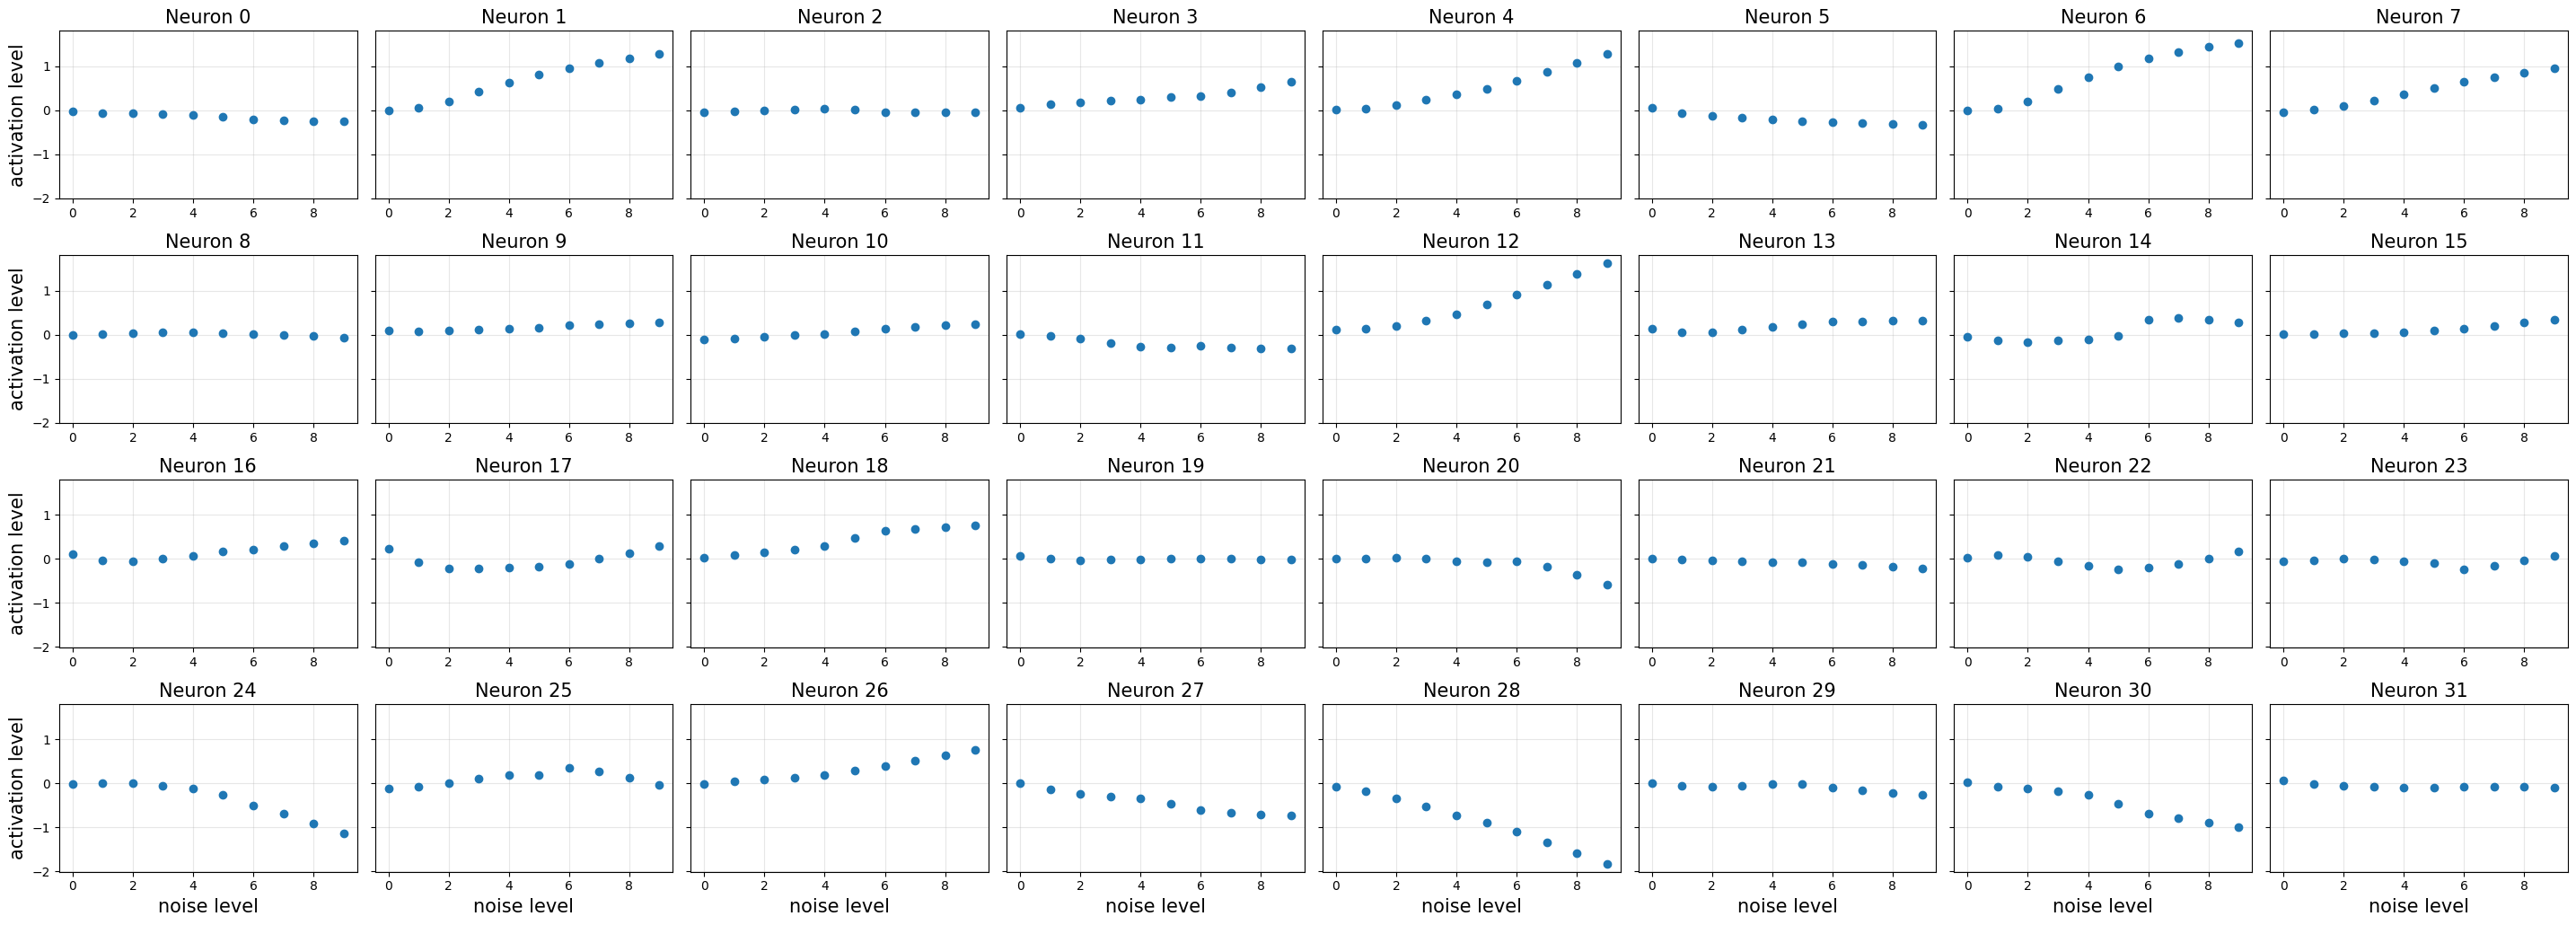

In [65]:
level = 1
class_id = 1
diff_vis = class_emb_diff_simgas[class_id][level]
plot_curve_grid(diff_vis.T,sharey=True,xlabel="noise level")

torch.Size([10, 32])

In [702]:
ff_flatten_0 = net_infer.ema_model.levels[0].encoder.weight.data.flatten(1).cpu()

In [703]:
ff_flatten_0_sort = ff_flatten_0[ff_flatten_0.norm(dim=1).sort().indices]

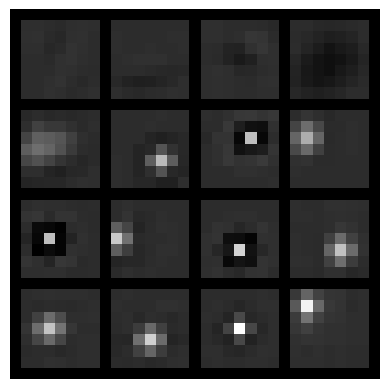

In [709]:
vis_patches(ff_flatten_0_sort.cpu())

In [61]:
# denosing at hgigh noise with conditioning

noise_level = 1.0
img_clean = torch.cat(x_ls)[:B].to(device)
img_noisy = mean_img.to(device) +  torch.randn_like(img_clean)*noise_level
# img_noisy =  img_clean + torch.randn_like(img_clean)*noise_level
sigma = torch.full((B,), float(noise_level), device=device, dtype=torch.float32)
class_labels = torch.full((B,), 0, device=device, dtype=torch.float32)
with torch.no_grad():
    a,decoded = net_infer.ema_model(img_noisy, noise_labels=sigma, return_feature = True, class_labels = class_labels)

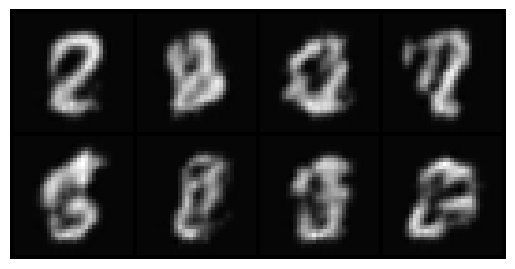

In [62]:
vis_patches(decoded[0].flatten(2).cpu(),ncol=4)